The .cyn file format
=============================================

For example:

1					###number of strokes in the file   
stroke 0				###keyword "stroke" and the index of the stroke
3					###number of samples in the stroke
0	0	0.0361797	0.050332	0.270588	29.7969		0.406232	-0.281259
1    	0.007	0.0356365	0.0532817	0.481119	28.7381		0.406232	-0.29501
2	0.014	0.0350476	0.0562231	0.509804	28.5938		0.406232	-0.296884

###the eight numbers are: (from left to right)
1) sample index (start from 0)
2) time stamp
3) x position (0-1)
4) y position (0-1)
5) pressure (0-1) 
6) rotation (in angles) 
7) tiltX (-1, 1)
8) tiltY (-1, 1)

In [1]:
import numpy
import matplotlib.pyplot as plt

In [2]:
FILE = "./helping-hand/original/hhdemoRelease/data/Face.cyn"

def load_strokes(file_path):  
    strokes = []
    with open(file_path) as f:
        start = False
        stroke = []
        for line in f.readlines():
            if line and line.startswith("stroke"):
                start = True
                stroke = []
                continue
            if start:
                if len(line) == 1:
                    start = False # reach the end of stroke
                    strokes.append(stroke.copy())
                    stroke = []
                elif len(line) > 30:
                    stroke.append(line)
        return strokes

In [3]:
def convert_strokes_to_points(strokes):
    processed_strokes = []
    for stroke in strokes:
        points = []
        for point in stroke:
            points.append([float(i) for i in point.split()])
        #print("length = ", len(points))
        processed_strokes.append(points.copy())
    return processed_strokes

In [5]:
def visualize_stroke_points(points):
    x = [p[2] for p in points]
    y = [1-p[3] for p in points]
    c = [[p[4], (p[6]+1)/2, (p[7]+1)/2] for p in points]
    plt.scatter(x, y, s=0.5, c=c)

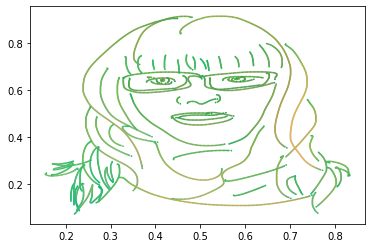

In [6]:
strokes = load_strokes(FILE)
stroke_points = convert_strokes_to_points(strokes)
for stroke in stroke_points:   
    visualize_stroke_points(stroke)

In [8]:
MAX_LEN = 200
# output format
# ready to use in neural networks
# 0 delta x
# 1 delta y
# 2 pressure
# 3 rotation
# 4 tilt X
# 5 tilt Y
# 6 x0
# 7 y0

def normalize_strokes(processed_strokes):
    normalized = []
    for stroke in processed_strokes:
        if len(stroke) > MAX_LEN:
            # need to resample to the max length
            continue 
        points = []
        x0 = stroke[0][2]
        y0 = stroke[0][3]
        lastx = x0
        lasty = y0
        for p in stroke:
            points.append([p[2] - lastx, p[3] - lasty, p[4], p[5], p[6], p[7], x0, y0])
            lastx, lasty = p[2], p[3]
        normalized.append(points.copy())
    return normalized

In [10]:
training_data = normalize_strokes(stroke_points)
print(training_data)

[[[0.0, 0.0, 0.137255, 0.0, 0.421857, -0.34376, 0.34389, 0.416915], [0.0006900000000000239, 0.0029200000000000337, 0.1403, 0.0, 0.421857, -0.34376, 0.34389, 0.416915], [0.0005870000000000042, 0.0029409999999999714, 0.141176, 0.0, 0.421857, -0.34376, 0.34389, 0.416915], [0.0006169999999999787, 0.002935999999999994, 0.163432, 0.0, 0.406232, -0.34376, 0.34389, 0.416915], [0.0006220000000000114, 0.002935000000000021, 0.177362, 0.0, 0.406232, -0.34376, 0.34389, 0.416915], [0.0006229999999999847, 0.002933999999999992, 0.192997, 0.0, 0.406232, -0.35241, 0.34389, 0.416915], [0.0005910000000000082, 0.002941000000000027, 0.215158, 0.0, 0.406232, -0.359386, 0.34389, 0.416915], [0.0005380000000000384, 0.0029509999999999814, 0.234021, 0.0, 0.406232, -0.359386, 0.34389, 0.416915], [0.0005580000000000029, 0.002948000000000006, 0.24667, 0.0, 0.406232, -0.359386, 0.34389, 0.416915], [0.0005699999999999594, 0.0029449999999999754, 0.255207, 0.0, 0.406232, -0.359386, 0.34389, 0.416915], [0.000549999999999

In [25]:
DELTA_T = 0.01
def rebuild_strokes(normalized_strokes):
    result = []
    for stroke in normalized_strokes:
        x0, y0 = stroke[0][6], stroke[0][7]
        lastx, lasty = x0, y0
        index = 0
        time = 0.0
        points = []
        for point in stroke:
            new_point = [index, time, lastx + point[0], lasty + point[1], point[2], point[3], point[4], point[5]]
            points.append(new_point)
            time += DELTA_T
            index += 1
            lastx, lasty = new_point[2], new_point[3]
        result.append(points.copy())
    return result

In [26]:
print(rebuild_strokes(training_data))

[[[0, 0.0, 0.34389, 0.416915, 0.137255, 0.0, 0.421857, -0.34376], [1, 0.01, 0.34458, 0.419835, 0.1403, 0.0, 0.421857, -0.34376], [2, 0.02, 0.345167, 0.422776, 0.141176, 0.0, 0.421857, -0.34376], [3, 0.03, 0.345784, 0.425712, 0.163432, 0.0, 0.406232, -0.34376], [4, 0.04, 0.346406, 0.428647, 0.177362, 0.0, 0.406232, -0.34376], [5, 0.05, 0.347029, 0.431581, 0.192997, 0.0, 0.406232, -0.35241], [6, 0.060000000000000005, 0.34762, 0.434522, 0.215158, 0.0, 0.406232, -0.359386], [7, 0.07, 0.348158, 0.437473, 0.234021, 0.0, 0.406232, -0.359386], [8, 0.08, 0.348716, 0.440421, 0.24667, 0.0, 0.406232, -0.359386], [9, 0.09, 0.349286, 0.443366, 0.255207, 0.0, 0.406232, -0.359386], [10, 0.09999999999999999, 0.349836, 0.446315, 0.271061, 0.0, 0.406232, -0.359386], [11, 0.10999999999999999, 0.35039, 0.449263, 0.293309, 0.0, 0.406232, -0.359386], [12, 0.11999999999999998, 0.351015, 0.452198, 0.305434, 0.0, 0.406232, -0.359386], [13, 0.12999999999999998, 0.35171, 0.455116, 0.308848, 0.0, 0.406232, -0.3593

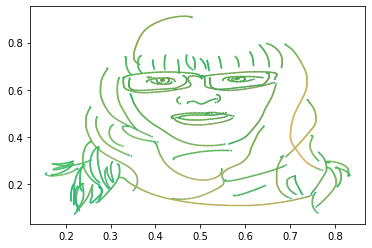

In [27]:
result_strokes = rebuild_strokes(training_data)
for stroke in result_strokes:   
    visualize_stroke_points(stroke)

In [51]:
def write_to_cyn_file(strokes, path):
    with open(path, 'w') as f:
        f.write('#\nVersion 0.0\n#\n\nphotoshop 5\n1\nunrelated\n\n')
        f.write(str(len(strokes)) + '\n')
        index = 0
        for stroke in strokes:
            f.write("stroke "+str(index)+"\n")
            f.write(str(len(stroke))+"\n")
            for points in stroke:
                f.write(" ".join([str(i) for i in points]) + "\n")
            f.write("\n")
            index += 1


In [52]:
write_to_cyn_file(rebuild_strokes(training_data), "test.cyn")